PulmoVision: CNN-based Tuberculosis & Pneumonia Detection from Chest X-Rays

 INSTALL DEPENDENCIES (to be run only once in terminal)

In [17]:
""" !pip install torch torchvision torchaudio
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install tqdm
!pip install kagglehub 
!pip install torchsummary """

' !pip install torch torchvision torchaudio\n!pip install scikit-learn\n!pip install matplotlib\n!pip install seaborn\n!pip install tqdm\n!pip install kagglehub \n!pip install torchsummary '

 IMPORT LIBRARIES

In [16]:
# Basic utilities
import os
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bars
import tqdm as notebook_t  # For training/validation loop progress

# Kaggle dataset access
import kagglehub

# PyTorch core
import torch
import torch.nn as nn                      # Neural network layers
import torch.optim as optim                # Optimizers
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms  # Datasets & transforms

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

# Model summary
from torchsummary import summary

# Image handling
from PIL import Image

 DATASET INTEGRATION

In [4]:
kaggle_path = "/kaggle/input/imbalanced-tuberculosis-and-pnuemonia-dataset/all_images"

if os.path.exists(kaggle_path):
    data_dir = kaggle_path
    print("✅ Using Kaggle dataset path:", data_dir)

else:
        path = kagglehub.dataset_download("roshanmaur/imbalanced-tuberculosis-and-pnuemonia-dataset")
        data_dir = os.path.join(path, "all_images")
        print("✅ Dataset downloaded to:", data_dir)

✅ Dataset downloaded to: C:\Users\ANKIT SARKAR\.cache\kagglehub\datasets\roshanmaur\imbalanced-tuberculosis-and-pnuemonia-dataset\versions\2\all_images


 DATA AUGMENTATION & LOADING

In [5]:
# Training transforms (with augmentations for robustness)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize all images to 224x224
    transforms.RandomRotation(20),             # Random rotation within ±20°
    transforms.RandomHorizontalFlip(),         # Random horizontal flip
    transforms.RandomVerticalFlip(),           # Random vertical flip
    transforms.ColorJitter(                    # Random brightness & contrast adjustments
        brightness=0.2,
        contrast=0.2
    ),
    transforms.ToTensor(),                     # Convert PIL Image → PyTorch Tensor
    transforms.Normalize([0.5], [0.5])         # Normalize pixel values to [-1, 1]
])

# Validation & Test transforms (no augmentations, only resize + normalize)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Keep input size consistent
    transforms.ToTensor(),                     # Convert to Tensor
    transforms.Normalize([0.5], [0.5])         # Normalize pixel values
])

# Load full dataset from directory
full_dataset = datasets.ImageFolder(root=data_dir, transform=val_test_transform)

# Remove "universal_test" class if it exists.
if "universal_test" in full_dataset.classes:
    print("⚠️ Removing 'universal_test' class...")
    new_samples = [
        (img, label) 
        for img, label in full_dataset.samples 
        if full_dataset.classes[label] != "universal_test"
    ]
    full_dataset.samples = new_samples
    full_dataset.targets = [s[1] for s in new_samples]
    full_dataset.class_to_idx = {
        cls: i for i, cls in enumerate(
            sorted(set(full_dataset.classes) - {"universal_test"})
        )
    }
    full_dataset.classes = sorted(full_dataset.class_to_idx.keys())

# Define dataset split sizes (70% train, 15% val, 15% test)
train_size = int(0.7 * len(full_dataset))
val_size   = int(0.15 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

# Perform the split
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

# Assign transforms to respective splits
train_ds.dataset.transform = train_transform      # Training uses augmentation
val_ds.dataset.transform = val_test_transform     # Validation uses clean images
test_ds.dataset.transform = val_test_transform    # Testing uses clean images

# Create DataLoaders for batching
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)   # Shuffle = True for training
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)    # No shuffle for evaluation
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)   # No shuffle for evaluation

# Dataset details
print("✅ Dataset loaded successfully")
print("Classes:", full_dataset.classes)
print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


✅ Dataset loaded successfully
Classes: ['Normal', 'Pneumonia', 'Tuberculosis']
Train: 10584 | Val: 2268 | Test: 2269


EXPLORATORY DATA ANALYSIS


 Class Distribution:
Normal: 9188 images
Pneumonia: 4145 images
Tuberculosis: 1788 images


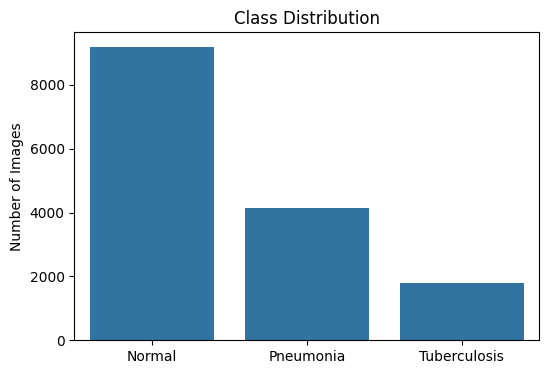

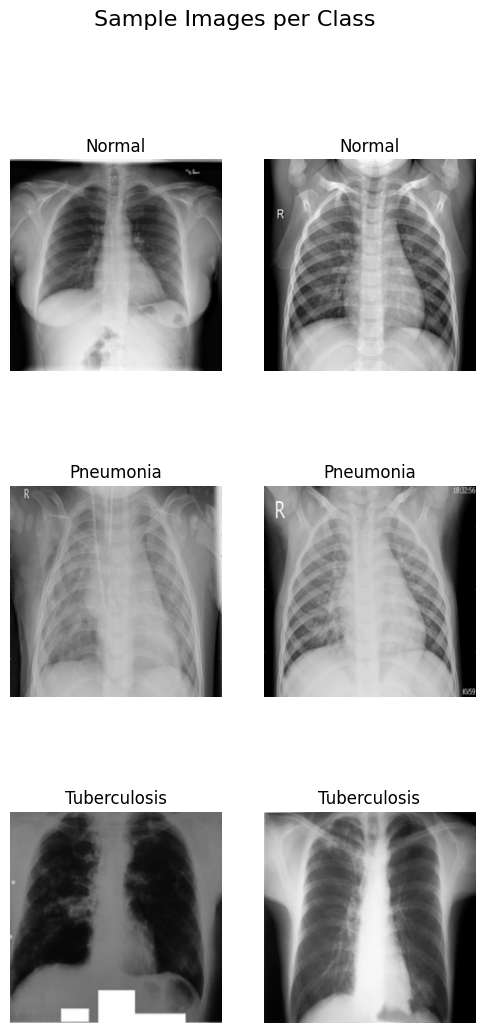


Image Dimension Stats (first 500 images):
Min size: 1098x662 | Max size: 4892x4892
Average size: 2800.5x2795.1


In [6]:
if __name__ == "__main__":
    from collections import Counter

    # 1. Check class distribution
    targets = [label for _, label in full_dataset.imgs]
    class_counts = Counter(targets)

    print("\n Class Distribution:")
    for i, cls in enumerate(full_dataset.classes):
        print(f"{cls}: {class_counts[i]} images")

    plt.figure(figsize=(6,4))
    sns.barplot(x=full_dataset.classes, y=[class_counts[i] for i in range(len(full_dataset.classes))])
    plt.title("Class Distribution")
    plt.ylabel("Number of Images")
    plt.show()

    # 2. Show random images from each class (2 per class)
    def show_classwise_images(dataset, classes, n=2):
        plt.figure(figsize=(n * 3, 4 * len(classes)))

        for class_idx, class_name in enumerate(classes):
            # Get indices for this class
            class_indices = [i for i, (_, label) in enumerate(dataset.imgs) if label == class_idx]
            selected_indices = np.random.choice(class_indices, n, replace=False)

            for j, idx in enumerate(selected_indices):
                image, label = dataset[idx]
                ax = plt.subplot(len(classes), n, class_idx * n + j + 1)
                plt.imshow(np.transpose(image.numpy(), (1,2,0)) * 0.5 + 0.5)  # unnormalize
                ax.set_title(class_name)
                ax.axis("off")

        plt.suptitle("Sample Images per Class", fontsize=16)
        plt.show()

    show_classwise_images(full_dataset, full_dataset.classes, n=2)

    # 3. Image size check (before transform)
    heights, widths = [], []
    for path, _ in full_dataset.imgs[:500]:  # check only first 500 for speed
        img = Image.open(path)
        widths.append(img.width)
        heights.append(img.height)
        img.close()

    print("\nImage Dimension Stats (first 500 images):")
    print(f"Min size: {min(widths)}x{min(heights)} | Max size: {max(widths)}x{max(heights)}")
    print(f"Average size: {np.mean(widths):.1f}x{np.mean(heights):.1f}")

 CNN MODEL DEFINITION

In [7]:
class XRayCNN(nn.Module):
    def __init__(self, num_classes):
        super(XRayCNN, self).__init__()
        # Convolution layers + Pooling
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)    # Final CLassification layer
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = XRayCNN(num_classes=len(full_dataset.classes)).to(device)


MODEL ARCHITECTURE DIAGRAM 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
          Flatten-10               [-1, 100352]               0
           Linear-11                  [-1, 256]      25,690,368
             ReLU-12                  [-1, 256]               0
          Dropout-13                  [-1, 256]               0
           Linear-14                   

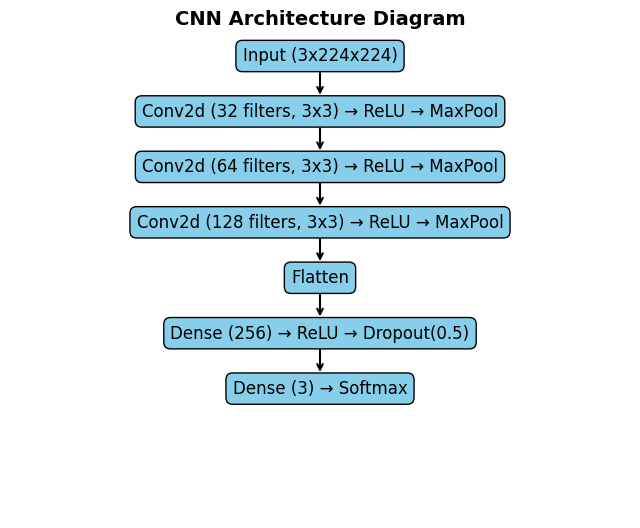

In [ ]:
# Model architecture summary (torchsummary only)
summary(model, (3, 224, 224))

def plot_cnn_architecture():
    layers = [
        "Input (3x224x224)",
        "Conv2d (32 filters, 3x3) → ReLU → MaxPool",
        "Conv2d (64 filters, 3x3) → ReLU → MaxPool",
        "Conv2d (128 filters, 3x3) → ReLU → MaxPool",
        "Flatten",
        "Dense (256) → ReLU → Dropout(0.5)",
        f"Dense ({len(full_dataset.classes)}) → Softmax"
    ]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis("off")
    
    # Draw each block
    for i, layer in enumerate(layers):
        ax.text(
            0.5, 1 - i*0.12, layer,
            fontsize=12, ha="center", va="center",
            bbox=dict(boxstyle="round,pad=0.4", facecolor="skyblue", edgecolor="black")
        )
        if i < len(layers) - 1:
            ax.annotate(
                "", xy=(0.5, 1 - (i+1)*0.12 + 0.03), xytext=(0.5, 1 - i*0.12 - 0.03),
                arrowprops=dict(arrowstyle="->", lw=1.5, color="black")
            )
    
    # Lift the title slightly so it won’t overlap
    plt.title("CNN Architecture Diagram", fontsize=14, fontweight="bold", y=1.05)
    plt.show()

# Call the function
plot_cnn_architecture()

 LOSS & OPTIMIZER

In [9]:
# Loss function: CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
# Optimizer: Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

 MODEL TRAINING 

In [10]:
def train_model(model, train_loader, val_loader, epochs=5):
    # Lists to store loss and accuracy for each epoch
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    
    for epoch in range(epochs):
        # Training :-
        model.train()  
        running_loss, correct, total = 0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):  
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()            # Clear previous gradients
            outputs = model(images)          # Forward pass
            loss = criterion(outputs, labels)# Compute loss
            loss.backward()                  # Backpropagation
            optimizer.step()                 # Update weights

            # Update running statistics
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        # Store epoch training metrics
        train_losses.append(running_loss/len(train_loader))
        train_accs.append(correct/total)

        # Validation :-
        model.eval()  
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():                          # No gradient computation during validation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        # Store epoch validation metrics
        val_losses.append(val_loss/len(val_loader))
        val_accs.append(val_correct/val_total)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_accs[-1]:.4f}")

    return train_losses, val_losses, train_accs, val_accs

# Train the model for 5 epochs
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, epochs=5)

Epoch 1/5: 100%|██████████| 331/331 [14:47<00:00,  2.68s/it]


Epoch 1/5 | Train Acc: 0.8439 | Val Acc: 0.9105


Epoch 2/5: 100%|██████████| 331/331 [14:23<00:00,  2.61s/it]


Epoch 2/5 | Train Acc: 0.9133 | Val Acc: 0.9250


Epoch 3/5: 100%|██████████| 331/331 [14:33<00:00,  2.64s/it]


Epoch 3/5 | Train Acc: 0.9326 | Val Acc: 0.9427


Epoch 4/5: 100%|██████████| 331/331 [14:30<00:00,  2.63s/it]


Epoch 4/5 | Train Acc: 0.9459 | Val Acc: 0.9563


Epoch 5/5: 100%|██████████| 331/331 [14:00<00:00,  2.54s/it]


Epoch 5/5 | Train Acc: 0.9512 | Val Acc: 0.9586


 TRAINING CURVES

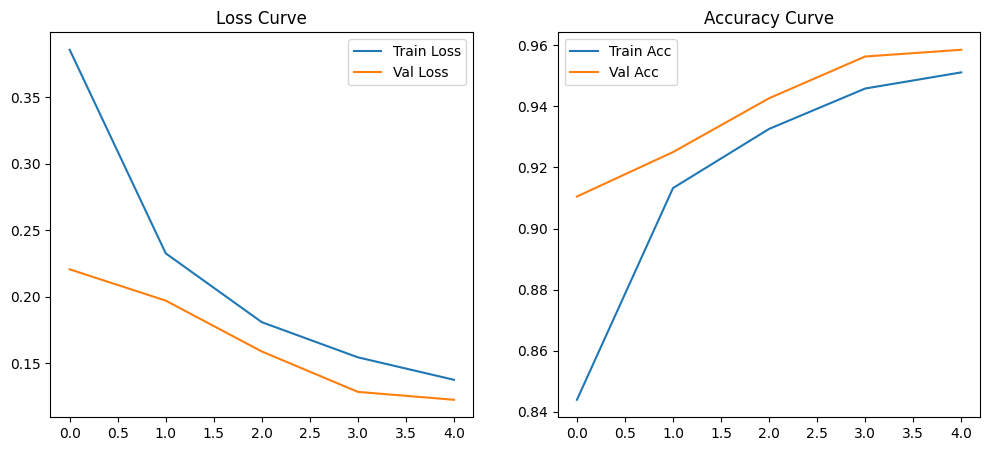

In [11]:
# Plot training and validation loss & accuracy curves to visualize model performance and check for overfitting
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend(); plt.title("Accuracy Curve")
plt.show()

 MODEL EVALUATION


Classification Report:
              precision    recall  f1-score   support

      Normal       0.93      0.98      0.96      1353
   Pneumonia       0.98      0.95      0.96       637
Tuberculosis       0.91      0.76      0.83       279

    accuracy                           0.95      2269
   macro avg       0.94      0.90      0.92      2269
weighted avg       0.95      0.95      0.94      2269



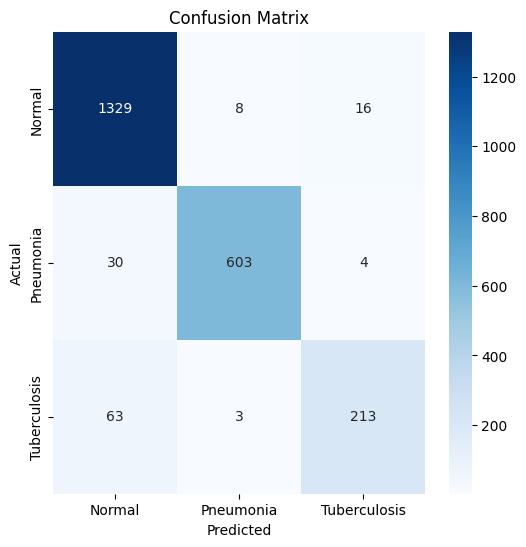

In [12]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification report shows per-class precision, recall, F1-score and overall performance
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=full_dataset.classes))

# Confusion matrix to visualize correct vs. misclassified predictions per class
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

 SAVE THE MODEL

In [13]:
torch.save(model.state_dict(), "xray_cnn.pth")
print("✅ Model saved as xray_cnn.pth")

✅ Model saved as xray_cnn.pth


 SINGLE IMAGE PREDICTION

In [14]:
def predict_image(image_path, model, classes):
    model.eval()  
    image = Image.open(image_path).convert("RGB")  # Load image
    transform = transforms.Compose([
        transforms.Resize((224,224)),  # Resize to CNN input size
        transforms.ToTensor(),          # Convert to tensor
        transforms.Normalize([0.5],[0.5])  # Normalize
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dim & move to device
    with torch.no_grad():
        output = model(image_tensor)  # Forward pass
        _, pred = torch.max(output, 1)  # Get predicted class index
    return classes[pred.item()]  # Return class name

# Test with a sample image
sample_image = os.path.join(data_dir, full_dataset.classes[0],
                            os.listdir(os.path.join(data_dir, full_dataset.classes[0]))[0])
print("Sample prediction:", predict_image(sample_image, model, full_dataset.classes))


Sample prediction: Normal


 VISUALIZE SAMPLE PREDICTIONS

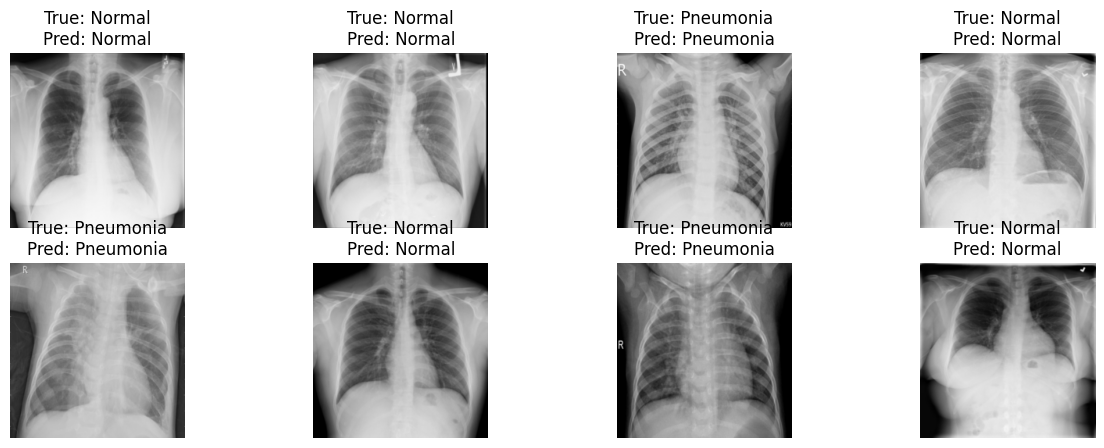

In [15]:
def show_predictions(model, loader, classes, n=8):
    model.eval()  # Set model to evaluation mode
    images, labels = next(iter(loader))  # Get a batch of images
    images, labels = images[:n].to(device), labels[:n].to(device)  # Take first n samples
    outputs = model(images)  # Forward pass
    _, preds = torch.max(outputs, 1)  # Get predicted class indices

    plt.figure(figsize=(15, 5))
    for i in range(n):
        ax = plt.subplot(2, n//2, i+1)
        # Denormalize and permute to HWC for matplotlib
        plt.imshow(images[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
        ax.set_title(f"True: {classes[labels[i]]}\nPred: {classes[preds[i]]}")
        ax.axis("off")
    plt.show()

# Display predictions for first 8 images from the test loader
show_predictions(model, test_loader, full_dataset.classes, n=8)
